# Long-short term Distributed Motion Planning

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env


import shapely

from panav.ORCA import VO, ORCA_Agent
from panav.SAMP import SA_MILP_Planning
from panav.util import unique_tx

%load_ext autoreload
%autoreload 2

## Construct the environment

## Plan waypoints with MILP for individual agents, ignoring inter-agent conflicts. Use a simple controller to generate $v_{pref}$ that tracks the waypoints. Use ORCA to convert $v_{pref}$ to safe velocities.

**Construct the environment**

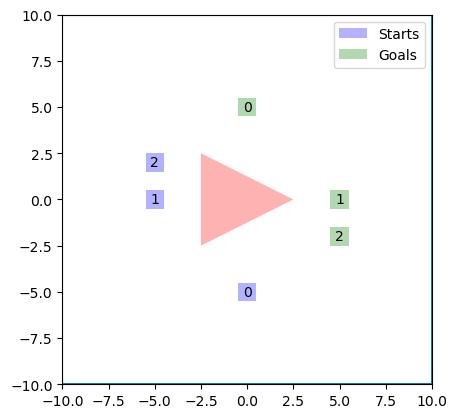

In [37]:

start_locs = np.array([[0,-5],[-5,0],[-5,2]])*1.0
goal_locs = np.array([[0,5],[5,0],[5,-2]])*1.0


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

limits = [(-10.0,10.0),(-10.0,10.0)]

O1 = PolygonRegion([(-2.5,2.5),(-2.5,-2.5),(2.5,0)])

env = NavigationEnv(limits,[O1],starts,goals)

draw_env(env)

**Compute individual paths that avoid all static obstacles**

In [38]:
agents = set(np.arange(len(start_locs)))

plans = []

bloating_r = 0.5
d = 2
K = 10
t0 = 0
vmax = 1.0

for agent in agents:
    start = env.starts[agent]
    goal = env.goals[agent]

    times, xs = SA_MILP_Planning(env,start,goal,vmax,bloating_r,\
                                 [],\
                                d,K,t0)

    times,xs = unique_tx(times,xs)
    plans.append(xs)

In [39]:


tau = 1 # The safe time interval. Can be generously long.
exec_tau = 0.2 * tau 
# The execution time of ORCA velocity.
# Should be much shorter than the safe interval tau.

pos = []
vs = [np.zeros(start_locs[0].shape) for a in agents]
v_prefs = [np.zeros(start_locs[0].shape) for a in agents]

protocol = 0

orcas = [ORCA_Agent(protocol,tau,bloating_r,vmax,p,v) 
         for p,v in zip(start_locs,vs)]

curr_wp_index = [0 for a in agents]


for _ in range(200):
    pos.append(np.array([a.p for a in orcas]))
    
    
   
    # Compute the preferred velocity.
    for agent in agents:
        wp = plans[agent][:,curr_wp_index[agent]]
        to_wp = wp-orcas[agent].p
        
        # See if the agent has reached the current waypoint.
        if np.linalg.norm(to_wp)<= bloating_r:  
            curr_wp_index[agent] = \
            np.min([curr_wp_index[agent]+1,   
                    plans[agent].shape[1]-1
                                  ])

        
        v_prefs[agent] = vmax * to_wp / np.linalg.norm(to_wp)
    
    # Update v_opt
    for a in agents:
        orcas[a].update_v_opt(v_prefs[a])
    
    # Compute the safe velocity.
    for a in agents:      
        orcas[a].update_v(v_prefs[a],env.obstacles,
                        [orcas[b] for b in agents-set([a])])
    
    # Execute the safe velocity.
    all_reached = True
    for a in agents:
        if np.linalg.norm(orcas[a].p \
                        - goals[a].project(orcas[a].p))\
                        >=1*bloating_r:
            orcas[a].p += orcas[a].v*exec_tau
            all_reached = False
    if all_reached:
        break

**Visualize the trajectories**

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


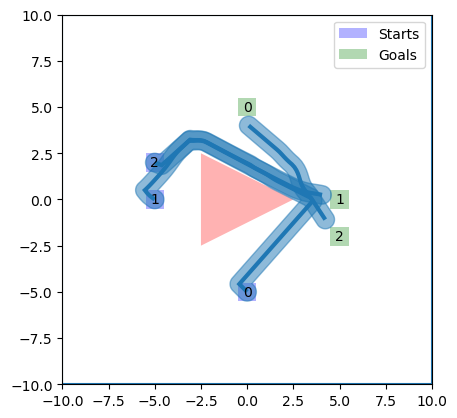

In [40]:

from shapely.plotting import plot_polygon, plot_line
pos = np.array(pos)

ax = plt.gca()
draw_env(env,[],ax)

for a in agents:
    line = shapely.geometry.LineString(pos[:,a,:])
    dilated = line.buffer(bloating_r)

    plot_line(line, ax=ax, add_points=False, linewidth=3)
    plot_polygon(dilated, ax=ax, add_points=False, alpha=0.5)

**Animate the motions**

In [41]:
from panav.viz import animation
from IPython.display import HTML, display

dt = 0.025

pos_to_ani = [pos[:,a,:].T for a in agents]
anim = animation(env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
plt.close() 

**Observation**: Letting $v_{pref}$ follow the individually planned paths is sufficient for the agents to reach their goals while staying safe.

## The problem of deadlock

On more challenging environments, planning waypoints for individual agents while ignoring inter-agent conflicts could be insufficient. For example, such paradigm could result in deadlock, as show below. 

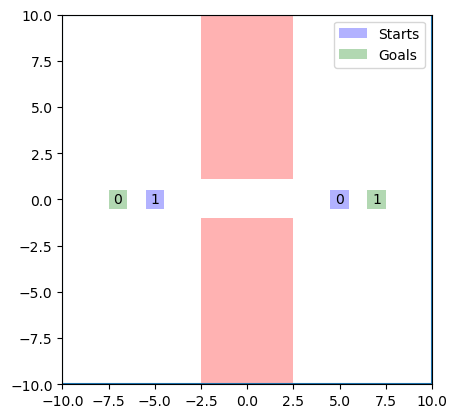

In [54]:

start_locs = np.array([[5,0],[-5,0]])*1.0
goal_locs = np.array([[-7,0],[7,0]])*1.0


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-2.5,2.5),(1.1,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

draw_env(env)

**Compute individual paths that avoid all static obstacles**

In [55]:
agents = set(np.arange(len(start_locs)))

plans = []

bloating_r = 0.5
d = 2
K = 10
t0 = 0
vmax = 1.0

for agent in agents:
    start = env.starts[agent]
    goal = env.goals[agent]

    times, xs = SA_MILP_Planning(env,start,goal,vmax,bloating_r,\
                                 [],\
                                d,K,t0)

    times,xs = unique_tx(times,xs)
    plans.append(xs)

In [56]:


tau = 1 # The safe time interval. Can be generously long.
exec_tau = 0.1 * tau 
# The execution time of ORCA velocity.
# Should be much shorter than the safe interval tau.

pos = []

v_prefs = [np.zeros(start_locs[0].shape) for a in agents]

protocol = 0

orcas = [ORCA_Agent(protocol,tau,bloating_r,vmax,p,v) 
         for p,v in zip(start_locs,vs)]

curr_wp_index = [0 for a in agents]


for _ in range(200):
    pos.append(np.array([a.p for a in orcas]))
    
    
    # See if the agent has reached the current waypoint.
    # Compute the preferred velocity.
    for agent in agents:
        wp = plans[agent][:,curr_wp_index[agent]]
        to_wp = wp-orcas[agent].p
        
        if np.linalg.norm(to_wp)\
                          <= bloating_r:
            curr_wp_index[agent] = np.min([
                            plans[agent].shape[1]-1,
                            curr_wp_index[agent]+1    
                                          ])
            
        
        v_prefs[agent] = vmax * to_wp / np.linalg.norm(to_wp)
    
    # Update v_opt
    for a in agents:
        orcas[a].update_v_opt(v_prefs[a])
    
    # Compute the safe velocity.
    for a in agents:      
        orcas[a].update_v(v_prefs[a],env.obstacles,
                        [orcas[b] for b in agents-set([a])])
    
    # Execute the safe velocity.
    all_reached = True
    for a in agents:
        if np.linalg.norm(orcas[a].p \
                        - goals[a].project(orcas[a].p))\
                        >=1*bloating_r:
            orcas[a].p += orcas[a].v*exec_tau
            all_reached = False
    if all_reached:
        break

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


**Visualize the trajectories**

/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


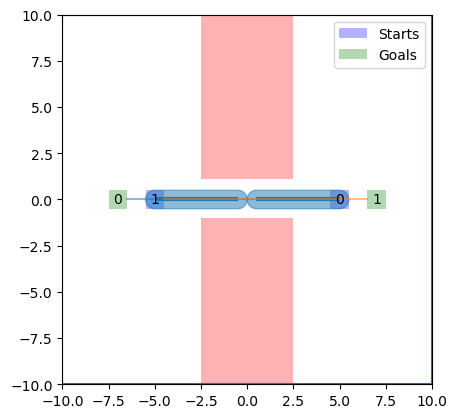

In [57]:

from shapely.plotting import plot_polygon, plot_line
pos = np.array(pos)

ax = plt.gca()
draw_env(env,plans,ax)

for a in agents:
    line = shapely.geometry.LineString(pos[:,a,:])
    dilated = line.buffer(bloating_r)

    plot_line(line, ax=ax, add_points=False, linewidth=3)
    plot_polygon(dilated, ax=ax, add_points=False, alpha=0.5)

**Animate the motions**

In [58]:
from panav.viz import animation
from IPython.display import HTML, display

dt = 0.025

pos_to_ani = [pos[:,a,:].T for a in agents]
anim = animation(env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
plt.close() 

The deadlock is because the individual planning does not address conflicts among different agents, but not a fault of ORCA. If the planning takes into account the conflict between agents, deadlock won't arise. 

Centralized MAMP algorithms like S2M2 can be used to compute a conflict-free multi-agent plan. But centralized algorithm typically does not scale well when the number of agents is large.

A combination of ORCA and individual planning can be used to resolve inter-agent conflicts in a distributed fashion, avoiding deadlick while keeping the computation efficient.

# Long-short term distributed motion planning

$\mathcal{X}:$ motion planning space.

$x_{i}^0,t_{i}^0$: starting time and location for agent $i$, assumed given. 

$\mathcal{O}_1,\mathcal{O}_2,...,\mathcal{O}_N$: static, polytopic obstacles.

$\mathcal{X}_i^{goal}$: goal region for agent $i$.

$v_{\max}:$ maximal speed of the agent.

$\tau:$ the safe horizon for $ORCA$, within which the agent does not collide with others.

$ORCA_i(\tau,x_i,\{x_j\text{ for all neighboring agents }j\}):$ the set of safe velocities of agent $i$, given its current location $x_i$ and neighoring agents' current locations $x_j$. It is represented by a set of linear constraints dependent on $\tau$, $x_i$, and $x_j$'s. 


The optimization problem to be solved by agent $i$:
$$
	\begin{aligned}
		&\min_{t_i^{1:K},x_i^{1:K}} t_i^K\\
		\text{subject to }&\\
		&x_i^{1:K}\in \mathcal{X}, x_i^K\in \mathcal{X}_i^{goal}\\
		&||x_i^{k+1}-x_i^{k}||\leq v_{\max}(t_i^{k+1}-t_i^k),~\forall k \in 1,2,...,K-1\\
		&\uparrow\text{(approximate with $\infty$ norm to preserve linearity)}\\
		& x_i^{1:K} \notin \mathcal{O}_{j}, \forall k\in 1:K, j\in 1:N\\
		&\uparrow\text{(modeled using big-$M$ method)}\\
		& (x_i^1-x_i^0)/\tau \in ORCA_i(\tau, x_i^0,\{x_j\text{ for all neighboring agents }j\})\\
		& t_i^1-t_i^0= \tau \\
		& t_i^{k+1}-t_i^k\geq 0,\forall k=0,1,2...,K-1
	\end{aligned}
$$

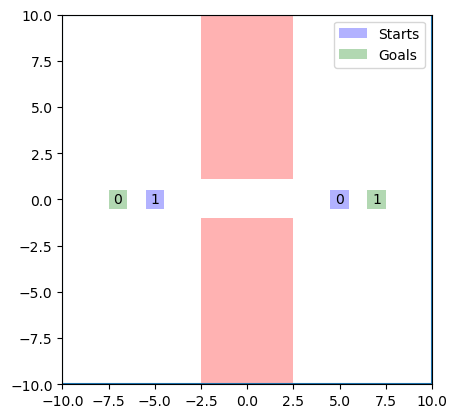

In [59]:

start_locs = np.array([[5,0],[-5,0]])*1.0
goal_locs = np.array([[-7,0],[7,0]])*1.0


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-2.5,2.5),(1.1,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

draw_env(env)

**Compute individual paths that avoid all static obstacles**

In [76]:
agents = set(np.arange(len(start_locs)))

plans = []

bloating_r = 0.5
d = 2
K = 10
t0 = 0
vmax = 1.0

safe_tau = 1.0

orcas = [ORCA_Agent(protocol=0,tau=safe_tau,
                    bloating_r=bloating_r,vmax=vmax,
                    init_p=p,init_v=v) 
         for p,v in zip(start_locs,vs)]

agent = 0
start = env.starts[agent]
goal = env.goals[agent]

M = 100 * np.max(np.abs(env.limits))
    
x = cp.Variable((d, K+1))
t = cp.Variable(K+1)

constraints = []

# Boundary constraints
constraints.append(x <= np.array(env.limits)[:,-1].reshape(-1,1) - 3*bloating_r)
constraints.append(x >= np.array(env.limits)[:,0].reshape(-1,1) + 3* bloating_r)

# Start and goal constraints
constraints.append(start.A @ x[:,0] <= start.b)
constraints.append(goal.A @ x[:,-1] <= goal.b)


# Static obstacle constraints
obs = [([],O) for O in env.obstacles]
lb_active = []
ub_active = []
for duration,O in obs:
    A, b= O.A,O.b

    H = A @ x-(b+ np.linalg.norm(A,axis=1) * bloating_r).reshape(-1,1) # Bloating radius

    alpha = cp.Variable((H.shape[0],K),boolean=True)

    constraints.append(H[:,1:] + M * (1-alpha)>=0)
    constraints.append(H[:,:-1] + M * (1-alpha)>=0)
    
# Time positivity constraint
constraints.append(t[0]==t0)
constraints.append(t[1:]>=t[:-1])

# Max speed constraints
vb = vmax*(t[1:]-t[:-1])
for i in range(d):
    diff = x[i,1:]-x[i,:-1]
    constraints.append(np.sqrt(2) * diff <= vb)
    constraints.append(- vb <= np.sqrt(2) * diff)
    
# ORCA constraints
us,ns = orcas[agent].neighbor_constraints([orcas[b] for b in agents - {agent}])
constraints+=[(x[:,1]-x[:,0]- safe_tau * (orcas[agent].v_opt+u/2)) @ n >= 0 for u,n in zip(us,ns)]
constraints.append(t[1]-t[0] == safe_tau) 

prob = cp.Problem(cp.Minimize(t[-1]),constraints)

prob.solve(solver='GUROBI')

15.556349186104047

In [64]:
times,xs = t.value, x.value

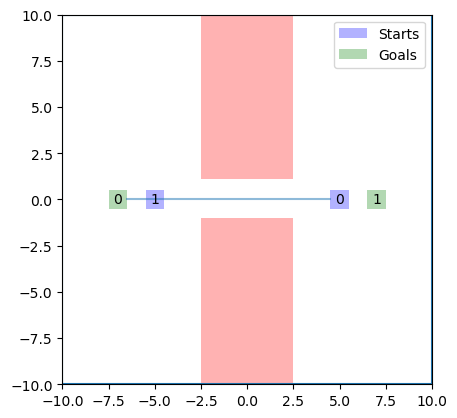

In [66]:

from shapely.plotting import plot_polygon, plot_line
pos = np.array(pos)

ax = plt.gca()
draw_env(env,[xs],ax)